(0.0, 20.0)

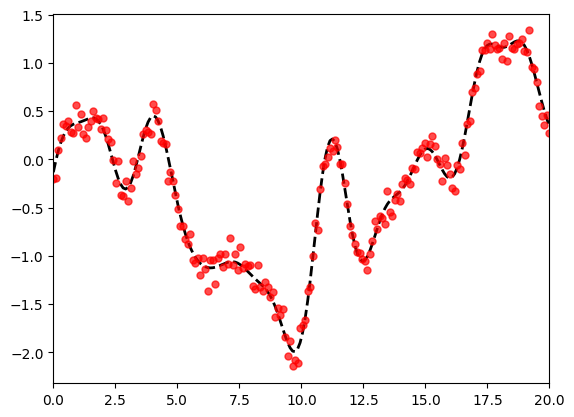

In [1]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random

#from scipy.special import dtype

import w 
import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [2]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)
gpflow.set_trainable(standard_gp.likelihood.variance, True)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)
f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)


In [5]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
w_diag=tf.Variable([1.]*200, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        W=tf.linalg.diag(w_diag)*sigma**2
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        loss=tf.reduce_sum(abs(tf.squeeze(y)-mean_loo))
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
    grad = tape.gradient(loss, [w_diag,variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [w_diag,variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_matto=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=0.12394547459708234>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.399000009065301>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999300924216>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=0.11141176175667977>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3980000250600549>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998558637184>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=0.11162490710478205>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.39700003589816596>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999782148825>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=0.11155267975637335>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.3960000467122936>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997084577977>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=0.11148855572947984>, <tf.Variable 'Variable:0' shape=() dtype=

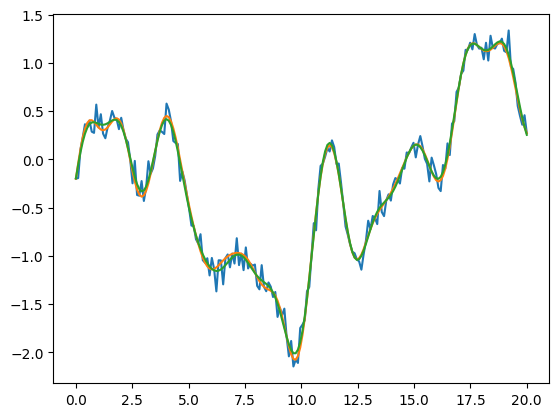

In [8]:
plt.plot(X,y)
plt.plot(X,pred_matto)
plt.plot(X,f_mean)

In [9]:
print(tf.reduce_mean((f - f_mean) ** 2), tf.reduce_mean(abs(f - f_mean)), "normal mean")
print(tf.reduce_mean((f -pred_matto) ** 2), tf.reduce_mean(abs(f - pred_matto)), "variant mean")

tf.Tensor(0.001168525584654297, shape=(), dtype=float64) tf.Tensor(0.028903548404855303, shape=(), dtype=float64) normal mean
tf.Tensor(0.00243816238637544, shape=(), dtype=float64) tf.Tensor(0.04100416634568127, shape=(), dtype=float64) variant mean


(array([1.32593658, 0.37526507, 0.40028274, 0.37526507, 0.32522973,
        0.3502474 , 0.3502474 , 0.55038877, 0.37526507, 0.57540644]),
 array([1.00000000e-03, 2.00858729e-01, 4.00717458e-01, 6.00576186e-01,
        8.00434915e-01, 1.00029364e+00, 1.20015237e+00, 1.40001110e+00,
        1.59986983e+00, 1.79972856e+00, 1.99958729e+00]),
 <BarContainer object of 10 artists>)

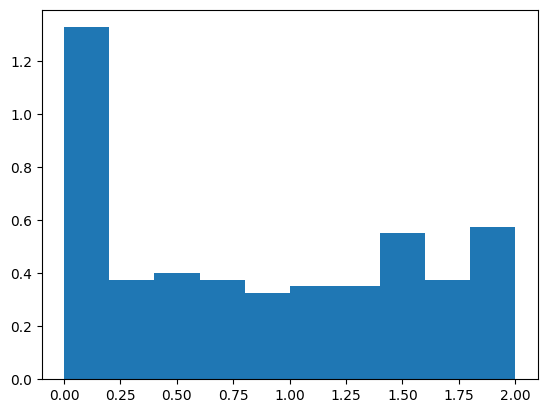

In [10]:

w1 = w_diag.value()
plt.hist(w1, density=True)